# Probability formulas

Let's explore the formulas used in the project and also visualize the impact of even tiny bias over a number can have over the played tickets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import itertools
from collections import defaultdict
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

# Base distribution: which number are preferred

Our goal is to find the players bias towards each number using only the lottery results and the number of player that won. To understand how the two are connected, we can start from a given base distribution, showing how likely players are to choose a given number from 1 to 49. Our final question is then: how likelly are players to choose a given set of 5 numbers.

Let's build the formula step-by-step. If you're impatient, you can skip to the last section of this page. as


In this file, we'll consider a fake preference distribution. Since we're talking about probability and all possible options are known, we must have:

$$ \sum_{i} B_i = 1 $$

In the graphs below, the dashed black represent what an uniform, that is unbiased, distribution would look like.

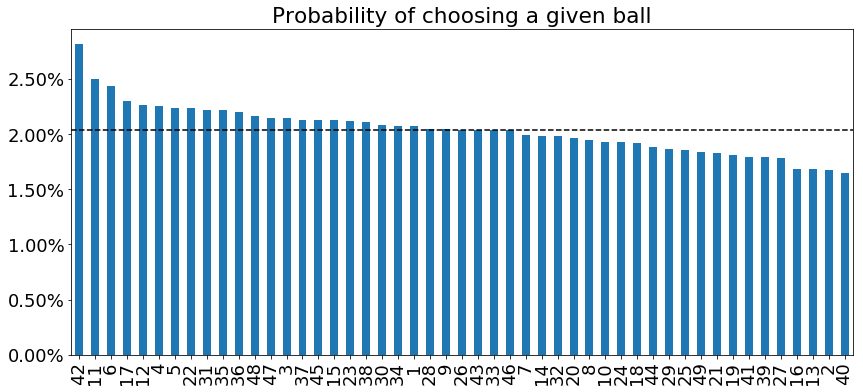

Most common is 1.7x more likelly than least common


In [2]:
N = 49
np.random.seed(17)
probs = np.exp(np.random.normal(0, 0.1, N))
probs = pd.Series(probs / np.sum(probs), index=range(1, 50))

probs.sort_values(ascending=False).plot.bar(figsize=(14, 6), color='C0')
plt.axhline(1 / N, color='black', linestyle='--')
plt.gca().get_yaxis().set_major_formatter(PercentFormatter(1))
plt.title('Probability of choosing a given ball')
plt.show()

print('Most common is {:.1f}x more likelly than least common'.format(probs.max() / probs.min()))

## Taking pairs

What is the likelihood of players choosing a given pair of numbers, say 12 and 17?

Rather surprisingly, it's **not** $ b_{12} * b_{17} $! And why not? Because:

1. after choosing 12 as their first number, the second (17) will be drawn from the remaining **48** numbers. It means, its likelihood is now $ b_{17} / (1 - b_{12}) $, since 12 is no longer in the pool. You can convince your self if you take the extreme case of a lottery with only two number from which players have to pick two. Do you see how the second number will certainly be picked?

2. a player can either pick 12 and then 17 or do it in the reverse order, the two cases should be added

That means:

$$ P(a, b) = a \frac{b}{1 - a} + b \frac{a}{1 - b} $$

The graph below ilustrate the most and least likely pairs from our example distribution. Note how the 1.7 times preference over a single number grows into 2.6x for pairs. This tendancy will be accentuaded as we grow the size of the set of chosen numbers.

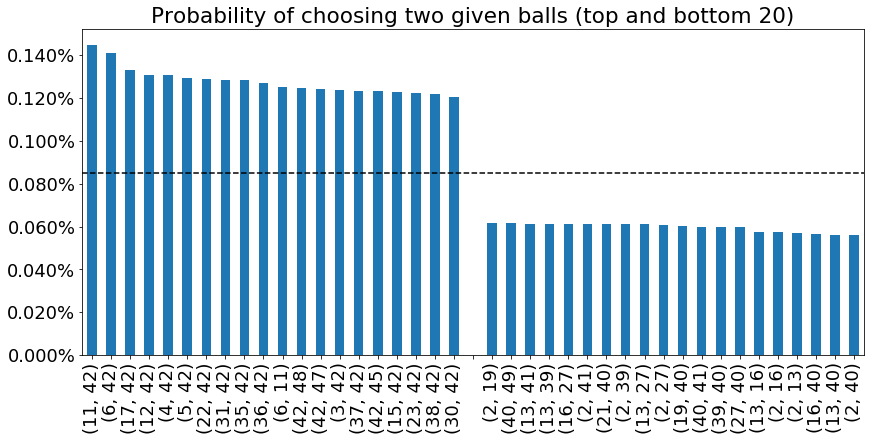

Most common is 2.6x more likelly than least common


In [3]:
def exact_comb_distro(probs, n_balls):
    distro = defaultdict(float)
    for perm in itertools.permutations(list(probs.index), n_balls):
        prob = 1
        remaing_prob = 1
        for ball in perm:
            ball_prob = probs[ball]
            prob *= ball_prob / remaing_prob
            remaing_prob -= ball_prob
        distro[tuple(sorted(perm))] += prob
    return pd.Series(distro)

def plot_comb_distro(distro, n_top=20):
    distro = distro.sort_values(ascending=False)
    head_tail = pd.concat([distro.head(n_top), pd.Series(float('nan'), index=['']), distro.tail(n_top)])
    head_tail.plot.bar(color='C0', figsize=(14, 6))
    plt.axhline(1 / len(distro), color='black', linestyle='--')
    plt.gca().get_yaxis().set_major_formatter(PercentFormatter(1))

probs_2 = exact_comb_distro(probs, 2)
plot_comb_distro(probs_2)
plt.title('Probability of choosing two given balls (top and bottom 20)')
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs_2.max() / probs_2.min()))

# Take it to the three

The reasoning is mostly the same when compared to taking pairs, however there are 6 ways of taking three numbers, so our formula will have 6 terms. Look how the denominator decreases within each term.

$$ P(a, b, c) = a \frac{b}{1 - a} \frac{c}{1 - a - b} +
a \frac{c}{1 - a} \frac{b}{1 - a - c} +
b \frac{a}{1 - b} \frac{c}{1 - b - a} + \\
b \frac{c}{1 - b} \frac{a}{1 - b - c} +
c \frac{a}{1 - c} \frac{b}{1 - c - a} +
c \frac{b}{1 - c} \frac{a}{1 - c - b} $$

You can already where we're reading to for our full 5-numbers set. There are 120 permutations of 5 numbers, so our final equation will have 120 adding terms, which one composed of 5 multipling terms.

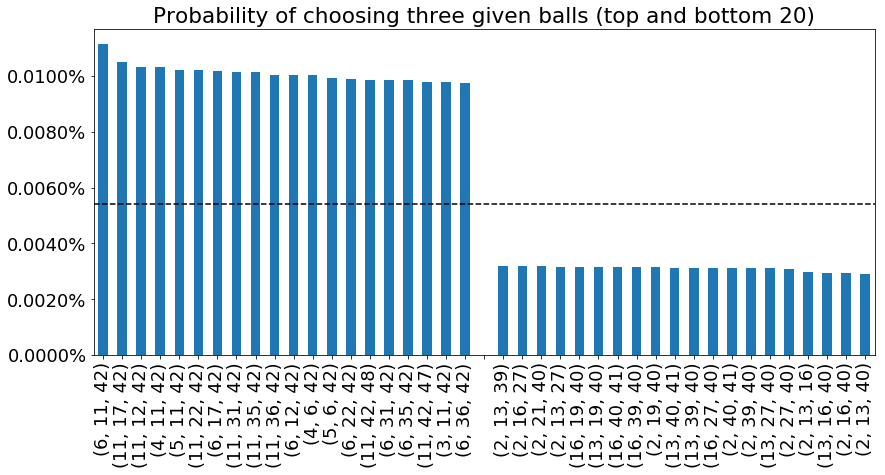

Most common is 3.8x more likelly than least common


In [4]:
probs_3 = exact_comb_distro(probs, 3)
plot_comb_distro(probs_3)
plt.title('Probability of choosing three given balls (top and bottom 20)')
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs_3.max() / probs_3.min()))

# Simplifying a bit

Unfortunately, the exact equation above will have too many terms for our case of 5-numbers sets. 120 terms may seen doable and we'll should test it, however we should remember the optimized will derivate this gigantic expression for each of the 49 variables (the base probabilities we're looking for).

In fact, the main concern is not computation time. Our dataset is rather small and we could compensate it with different techniques. My concern is numerical stability! With a formula with *many* adding and multipling similar terms, the errors in the float operations can add up and sometimes just give straight up unacceptable results. I don't understand enough about the issue in fact, it's more of a fear.

The idea is to cut corners and simplify our equation. We'd be losing precision for performance and stability. Deal!

The bad thing about our formula is that each factor is different, making it hard to squeeze all them together. What if we replaced the denominator with something more predictable, like the average of the arguments?

From the 3-numbers set above, see how all denominators will be factored out (here $\rho$ is the average of a, b, c):

$$ P(a, b, c) = \frac{6 a b c}{(1 - \rho) (1 - 2 \rho)} $$

It's a lot simpler in fact. So much so, we can now write our full 5-number-set formula:

$$ P(a, b, c, d, e) = \frac{120 a b c d e}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

Below an example of the difference between the exact and this simplified formula. It's precise to the 4th significant digit:

In [5]:
def exact_prob(probs, numbers):
    result = 0
    for perm in itertools.permutations(numbers):
        term = 1
        remaing_prob = 1
        for number in perm:
            prob = probs[number]
            term *= prob / remaing_prob
            remaing_prob -= probs[number]
        result += term
    return result

def simple_prob(probs, numbers):
    term = 1
    remaing_prob = 1
    avg = probs[numbers].mean()
    for number in numbers:
        term *= probs[number] / remaing_prob
        remaing_prob -= avg
    return math.factorial(len(numbers)) * term

top_3_bottom_2 = [42, 11, 6, 2, 40]
exact = exact_prob(probs, top_3_bottom_2)
simple = simple_prob(probs, top_3_bottom_2)
print('{:.9%}'.format(exact))
print('{:.9%}'.format(simple))

0.000071151%
0.000071136%


# Conclusion

## Exact form

$$ E[B] = \left ( \prod B_i \right ) \cdot
    \left ( \sum_{g \in perm(B)} 
        \prod_{k = 1}^{len(B) - 1} \frac{1}{1 - \sum_{j = 1}^{k} g_j}
    \right ) $$
    
## Approximate form

$$ \hat{E}[B] = \left ( \prod B_i \right ) \cdot len(B) ! \cdot \left (
    \prod_{k = 1}^{len(B) - 1} \frac {1} {1 - k \cdot avg(B) }
\right ) $$